Notebook to recplicate the results for our toy problem

In [1]:
import copy
import torch.nn as nn
import torch
from FrEIA.framework import *
from FrEIA.modules import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
device = torch.device("cuda:0")

In [2]:
class preprocessor():
    """
    Used to save initial means and range of the parameters and
    applies the preprocessing
    
    """
    def __init__(self, params):
        self.means = params.mean(dim = 0)
        self.max = torch.abs(params-self.means).max(dim = 0)[0]+1e-5
 
    def __call__(self, params, fwd = True):
        if fwd:
            return torch.arctanh((params - self.means)/self.max)
        else:
            return torch.tanh(params) * self.max + self.means

def get_linear_subnet(N, inp_size, hidden_size, out_size):
    """
    Helper function to get linear network with ReLU activation
    N: amount of layers, not including the final linear output layer
    inp_size: dimension of the input
    hidden_size: width of the N-1 hidden layers
    out_size: dimension of the output
    """
    if N == 0:
        return None
    layer_list = []
    layer_list.append(nn.Linear(inp_size, hidden_size))
    layer_list.append(nn.ReLU())
    for i in range(N-1):
        layer_list.append(nn.Linear(hidden_size, hidden_size))
        layer_list.append(nn.ReLU())
    layer_list.append(nn.Linear(hidden_size, out_size))
    return nn.Sequential(*layer_list).to(device)


class cINN(nn.Module):
    """
    cINN baseclass, using cubic spline blocks.
    inp_size: dimension of the input
    cond_size: dimension of the conditions
    num_blocks: amount of coupling blocks used
    sub_layers: amount of linear layers in the subnetworks
    sub_width: width of the subnetworks
    lr: learning rate, scheduler used is reduce_on_plateau
    """
    
    def __init__(self, inp_size, cond_size, num_blocks = 5, sub_layers = 2, sub_width = 128, lr = 2e-4):
        super(cINN, self).__init__()
        self.input_size = inp_size
        self.cond_size = cond_size
        constructor_fct = lambda x_in, x_out: get_linear_subnet(sub_layers, 
                                                                x_in,
                                                                sub_width,
                                                                x_out)

        block_kwargs_cube = {
                        "num_bins": 60,
                        "subnet_constructor": constructor_fct,
                        "bounds_init": 5,
                        "permute_soft": False
                           }
        
        block_kwargs_affine = {
                        "subnet_constructor": constructor_fct,
                        "permute_soft": True
                           }
        
        inp_size = (inp_size,)        
        nodes = [InputNode(*inp_size, name='inp')]
        cond_node = ConditionNode(*(cond_size,))
        for i in range(num_blocks):
            nodes.append(Node(
                    [nodes[-1].out0],
                    CubicSplineBlock,
                    block_kwargs_cube,
                    conditions = cond_node,
                    name = f"block_{i}",
               ))
            
        nodes.append(OutputNode([nodes[-1].out0], name='out'))
        nodes.append(cond_node)
        self.model = GraphINN(nodes, verbose=False).to(device)
        self.params_trainable = list(filter(
                lambda p: p.requires_grad, self.model.parameters()))
        n_trainable = sum(p.numel() for p in self.params_trainable)
        print(f"Number of cINN parameters: {n_trainable}", flush=True)
        
        self.optimizer = torch.optim.AdamW(
                self.params_trainable,
                lr = lr,
                betas =[0.9, 0.99],
                eps = 1e-6,
                weight_decay = 0
            )
        self.scheduler =  torch.optim.lr_scheduler.ReduceLROnPlateau(
                self.optimizer,
                verbose = True
            )
    def forward(self, x, cond = None, rev = False):
        return self.model(x, c = cond, rev = rev)


    
class Estimator():
    """
    Wrapper for training the cINN and inference
    """
    def __init__(self, cinn):
        self.cinn = cinn
    
    def metrik(self, true, data, gauss):
        """
        Used to measure the distance between truth and generated parameters
        Better interpretable than the Loss function
        """
        with torch.no_grad():
            output, _ = self.cinn(gauss, data, rev = True)
            output = torch.abs(prepper(output, fwd = False) - prepper(true, fwd = False))
            output = torch.mean(output, dim = 0).cpu().numpy()
        print(output)
        return output
    
    def train(self, epochs, xtrain, ytrain, batch_size):
        """
        Trains the cINN and shows loss and metric plots
        epochs: amount of epochs to train
        xtrain: training parameters
        ytrain: corresponding time series
        batch_size: Batch size used for the training
        """
        loss_curve = []
        metrics_curve = []
        zeros = torch.zeros(batch_size,4).to(device)
        for epoch in range(epochs):
            epoch_index = np.random.permutation(len(xtrain))
            epoch_losses = 0
            for i in range(len(xtrain)//batch_size):

                ysamps = ytrain[epoch_index][i*batch_size:(i+1)*batch_size]
                xsamps = xtrain[epoch_index][i*batch_size:(i+1)*batch_size]
                
                self.cinn.optimizer.zero_grad()
                gauss, jac = self.cinn(xsamps, ysamps)
                loss = torch.mean(gauss**2/2) - torch.mean(jac)/gauss.shape[1]
                    
                loss.backward()
                self.cinn.optimizer.step()

                epoch_losses += loss.item()/(len(xtrain)//batch_size)
            loss_curve.append(epoch_losses)
            metrics_curve.append(self.metrik(xsamps, ysamps, zeros))
            self.cinn.scheduler.step(epoch_losses)
            print("Epoch:", epoch + 1)
            print("Loss:", epoch_losses)
        plt.plot(np.arange(len(loss_curve)),np.array(loss_curve), label = "Loss")
        metrics_curve = np.array(metrics_curve)
        plt.ylabel("Loss")
        plt.xlabel("Epoch")
        plt.show()
        for i in range(metrics_curve.shape[1]):
            plt.plot(np.arange(len(loss_curve)), metrics_curve[:,i], label = f"Metric $x_{i}$")
        plt.legend()
        plt.xlabel("Epoch")
        
    def inference(self, data_point, true_param):
        """
        Predicts a parameter distribution for given time series
        Overlays the true parameter to see how well the network performs
        """
        outputs = []
        with torch.no_grad():
            for i in range(100):
                gauss = torch.randn(2000,self.cinn.input_size).to(device)
                cond = data_point.repeat(2000,1).to(device)
                output, _ = self.cinn(gauss, cond, rev = True)
                outputs.append(output)
        output = prepper(torch.cat(outputs, dim = 0), fwd = False).detach().cpu()
        fig, axis = plt.subplots(2,2, figsize = (10,10))
        for i in range(4):
            ax = axis[int((i-i%2)/2),i%2]
            ax.hist(output.numpy()[:,i], bins = 100, density = True, label = "Generated")
            ax.axvline(true_param[i], color = "r", label = "Truth")
            ax.set_xlabel(f"$x_{i}$", fontsize = 12)
            ax.legend()
            if i%2 == 0:
                ax.set_ylabel("Normalized", fontsize = 12)

In [3]:
params = torch.rand(500000,4)*np.array([0.1,140,140,0.3])
prep = preprocessor(params)
prepped =prep(params)

Number of cINN parameters: 244420
[0.02322119 0.01777781 0.02042688 0.01659507]
Epoch: 1
Loss: -0.4540476209109591
[0.01173121 0.01118217 0.01324582 0.01018665]
Epoch: 2
Loss: -2.2026389099887953
[0.00833107 0.01040623 0.00824828 0.00850159]
Epoch: 3
Loss: -2.6208555919607894
[0.00785166 0.00803305 0.00829022 0.00737722]
Epoch: 4
Loss: -2.8131001093952936
[0.0104966  0.00761131 0.00646885 0.00736665]
Epoch: 5
Loss: -2.904893331920978
[0.00916462 0.00691387 0.00628002 0.0065837 ]
Epoch: 6
Loss: -3.0353096883321524
[0.00685045 0.00672235 0.00547812 0.00614576]
Epoch: 7
Loss: -3.1100163287723186
[0.00698579 0.00982178 0.00582336 0.00638178]
Epoch: 8
Loss: -3.07600121399791
[0.00576854 0.00595113 0.00585192 0.00540818]
Epoch: 9
Loss: -3.1927891318331056
[0.00540729 0.00603489 0.00485476 0.00520955]
Epoch: 10
Loss: -3.242209456630589
[0.00527631 0.00624326 0.00465485 0.00528951]
Epoch: 11
Loss: -3.2346237123627017
[0.00510938 0.00534783 0.0045438  0.00535853]
Epoch: 12
Loss: -3.342762760280

[0.00224357 0.00236743 0.00176053 0.00184579]
Epoch: 101
Loss: -4.5114835857116065
[0.00232744 0.00251286 0.00178975 0.00189899]
Epoch: 102
Loss: -4.510348634621533
[0.00203925 0.00250401 0.00182215 0.00191468]
Epoch: 103
Loss: -4.5157825184851585
[0.00206079 0.00228544 0.00181852 0.00188008]
Epoch: 104
Loss: -4.519078161298614
[0.0020559  0.00267867 0.00178862 0.00182804]
Epoch: 105
Loss: -4.515477160817572
[0.00194586 0.00235237 0.00169083 0.00190406]
Epoch: 106
Loss: -4.52481058455005
[0.00226406 0.00245487 0.00180617 0.00189343]
Epoch: 107
Loss: -4.528804705315031
[0.0022546  0.00252438 0.00172583 0.00185858]
Epoch: 108
Loss: -4.5291574025891475
[0.0021032  0.00273337 0.0017447  0.00186629]
Epoch: 109
Loss: -4.5362801994245086
[0.00218748 0.00221601 0.00181301 0.00176487]
Epoch: 110
Loss: -4.536180501131668
[0.00204511 0.00265199 0.00183012 0.00192282]
Epoch: 111
Loss: -4.5373584609670745
[0.00215096 0.00236782 0.00176569 0.00184669]
Epoch: 112
Loss: -4.543311394367021
[0.00202039 

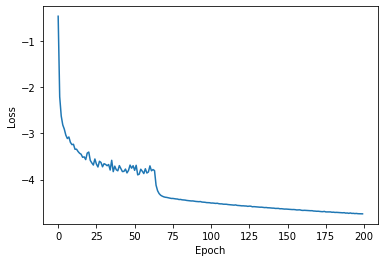

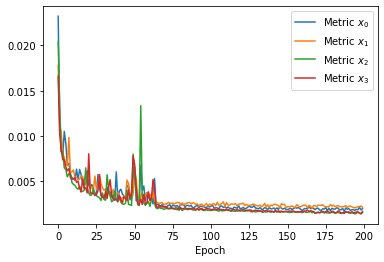

In [4]:
cinn = cINN(4, 4)

net = Estimator(cinn)
x = torch.rand(200000, 4, device = device, dtype = torch.float)
prepper = preprocessor(x)

x_prepped = prepper(x)
net.train(200, x_prepped, x, 2048)

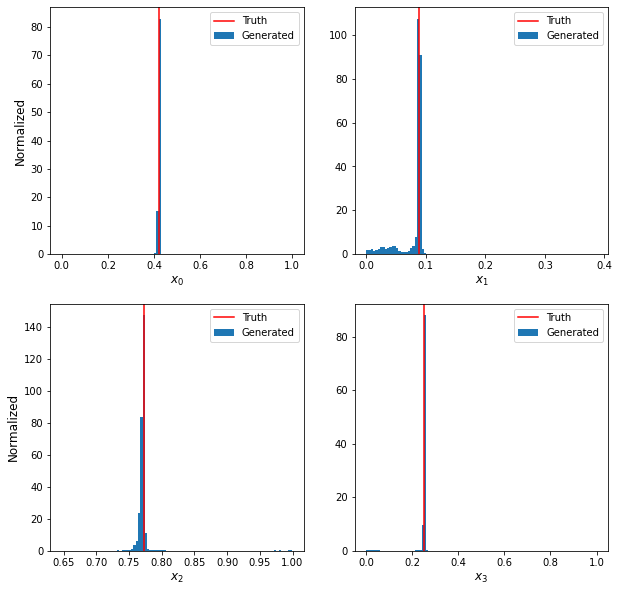

In [5]:
x_test = torch.rand(6, device = device, dtype = torch.float)
net.inference(x_test, x_test)